                                            Data Science Group Project 

*Created By:* Julia Cunningham, Arnav Dhablania, Nolan Bishop, and Shaurya Ahuja

*Date Created:* December 1, 2024

## Introduction

This project helps a UBC Computer Science research group study how people play video games. They use a Minecraft server to track players' actions in the game. However, they face challenges like finding the right players to recruit and ensuring they have enough resources, such as software and hardware, to handle all the players.

The main question we want to answer here is: "Which experience level of players is most likely to provide a large amount of data?" This will help focus recruitment on those players.

## Data Description 
We are describing the two given datasets below but we will only be using the players dataset for our analysis. 

i) Sessions Dataset: 
Observations: 1,535 observations
Variables: 5
hashedEmail: (chr) Unique identifier for each player.
start_time: (chr) Session start time in DD/MM/YYYY HH:MM
end_time: (chr) Session end time in DD/MM/YYYY HH:MM
original_start_time: (dbl) Standardized Starting Timestamp
original_end_time: (dbl) Standardized Ending Timestamp
-Issues: i) Missing Values in end_time and original_end_time
ii) start_time and end_time need to be converted to DateTime
iii) Encoding Categorical variables such as experience and gender will need encoding if included in a predictive model. -Data collection was probably done by tracking individuals' gaming sessions

ii) Players Dataset:
Observations: 196 observations
Variables: 9
experience: (chr) Player’s experience level.
subscribe: (lgl) Indicates subscription status.
hashedEmail: (chr) Unique identifier for each player.
name: (chr) Player’s name.
gender: (chr) Gender of the player.
age: (dbl) Standardized Ending Timestamp
indiviualId: (lgl) No data.
organizationName: (lgl) No data.
-Issues: No data in individual and organizationName
-Data collection was probably obtained through user profiles

## Method and Results

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

First we loaded the dataset and wrangle the data by selecting the "experience" , "gender", and "played_hours" columns. Then we will change the experience and gender data types to categorical data types. 

In [46]:
players <- read_csv('data/players.csv')|>
        select(experience, played_hours, gender) |>
        mutate(gender = as.factor(gender), experience = as.factor(experience))

players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,gender
<fct>,<dbl>,<fct>
Pro,30.3,Male
Veteran,3.8,Male
Veteran,0.0,Male
Amateur,0.7,Female
Regular,0.1,Male
⋮,⋮,⋮
Amateur,0.0,Female
Veteran,0.3,Male
Amateur,0.0,Prefer not to say


Then we visualized our data to get an idea of the relations between our variables.

We first calculated average played hours by both experience and gender, then plotted the relation as a bar graph.

No summary function supplied, defaulting to `mean_se()`
No summary function supplied, defaulting to `mean_se()`


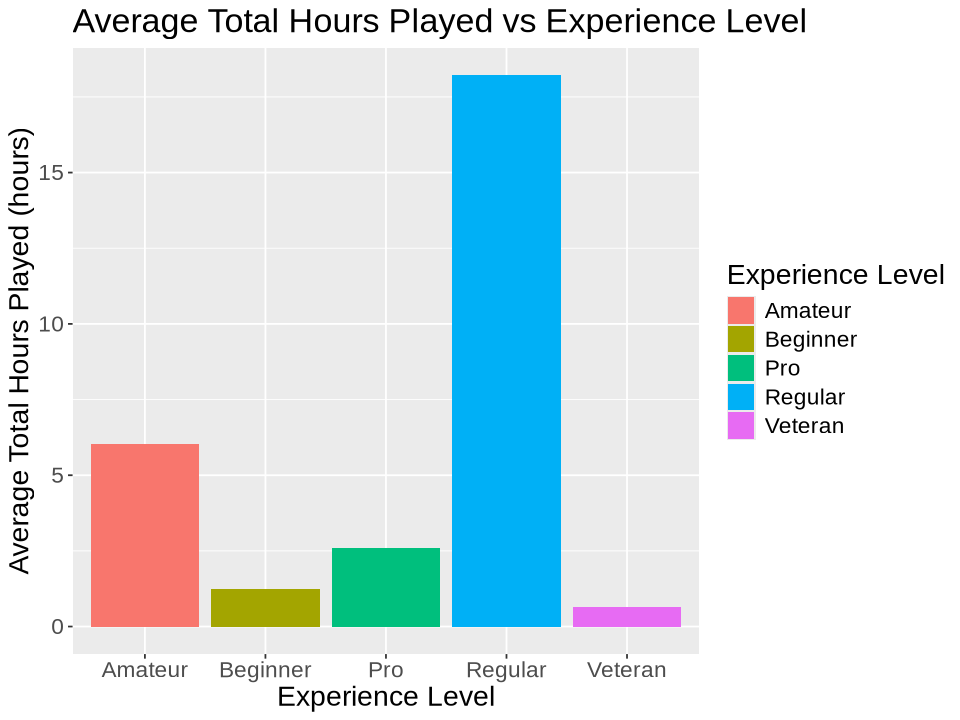

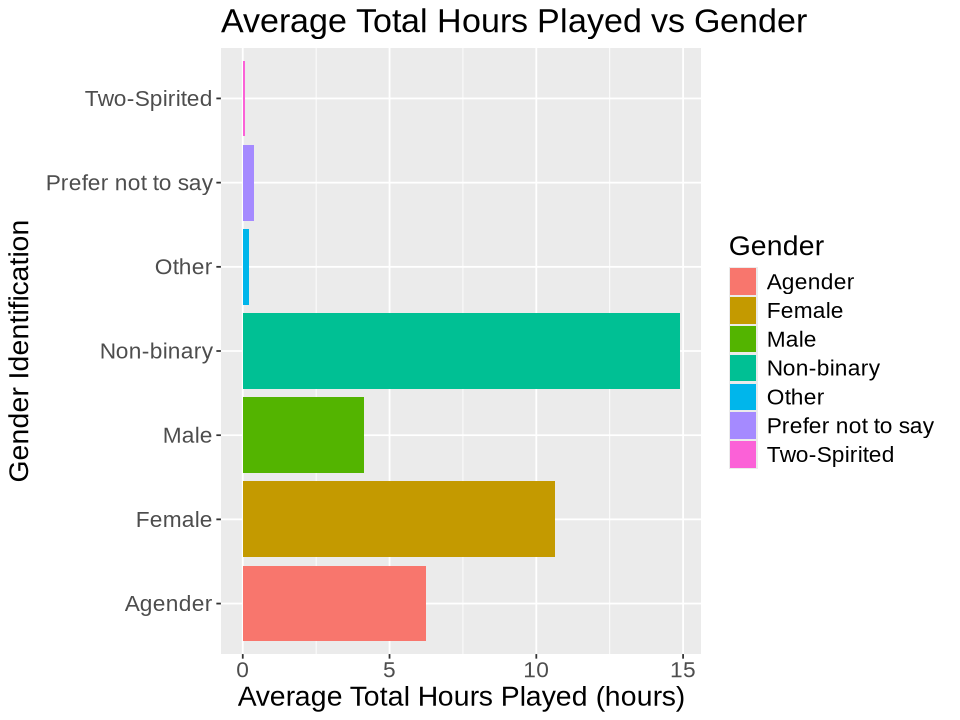

In [64]:
options(repr.plot.width = 8, repr.plot.height = 6)

players_exp_mean <- players |>
    group_by(experience) |>
    summarize(played_hours = mean(played_hours))


players_mean_plot <- ggplot(players_exp_mean, aes(x = experience, y = played_hours, fill = experience)) +
    geom_bar(stat = "summary") +
    labs(title = "Average Total Hours Played vs Experience Level", x = "Experience Level", 
         y = "Average Total Hours Played (hours)", fill = 'Experience Level') + 
    theme(text = element_text(size = 17))
players_mean_plot


players_gender_mean <- players |>
    group_by(gender) |>
    summarize(played_hours = mean(played_hours))

              
players_mean_plot <- ggplot(players_gender_mean, aes(x = played_hours, y = gender, fill = gender)) +
    geom_bar(stat = "summary") +
    labs(title = "Average Total Hours Played vs Gender", x = "Average Total Hours Played (hours)",
         y = "Gender Identification", fill = 'Gender') + 
    theme(text = element_text(size = 17))
players_mean_plot

We chose K-nearest neighbor (KNN) regression because it predicts numerical values and works well with non-linear relationships. Since the visualizations suggest the variables might not have a linear relationship, KNN is a better choice than linear regression.

To use KNN, all variables must be numerical. Therefore, we need to encode the categorical "experience" and "gender" columns. We'll create a new column, encoded_experience, where 1 represents Amateur, 2 is Beginner, 3 is Regular, 4 is Pro, and 5 is Veteran. encoded_gender will be represented with 1 as Agender, 2 as Female, 3 as Male, 4 as Non-binary, 5 as Prefer not to say, and 6 as Two-Spirited.

We will then get rid of any NA values in encoded_gender.

In [47]:
encoded_players <- players |>
    mutate(encoded_experience = case_when(
        experience == "Amateur" ~ 1,
        experience == "Beginner" ~ 2,
        experience == "Regular" ~ 3,
        experience == "Pro" ~ 4,
        experience == "Veteran" ~ 5)) |>
    mutate(encoded_gender = case_when(
        gender == "Agender" ~ 1,
        gender == "Female" ~ 2,
        gender == "Male" ~ 3,
        gender == "Non-binary" ~ 4,
        gender == "Prefer not to say" ~ 5,
        gender == "Two-Spirited" ~ 6)) |>
    select(played_hours, encoded_experience, encoded_gender) |>
    filter(encoded_gender != 'NA')
    

encoded_players

played_hours,encoded_experience,encoded_gender
<dbl>,<dbl>,<dbl>
30.3,4,3
3.8,5,3
0.0,5,3
0.7,1,2
0.1,3,3
⋮,⋮,⋮
0.0,1,3
0.0,1,2
0.3,5,3


Then we split the data into training and testing datasets of sizes 75% and 25%. 
We used set.seed(1) to ensure reproducability in our code

In [48]:
set.seed(1)
players_split <- initial_split(encoded_players, prop = .75, strata = played_hours)

players_training <- training(players_split)
players_testing <- testing(players_split)

Next we found the most optimal K value for our model. This involved using a 5 fold cross validation to and selecting K values from a range of 1 to 50. We selected the K value that resulted in the lowest RMSPE.

In [45]:
set.seed(1)
players_recipe <- recipe(played_hours ~ ., data = players_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())


knn_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = tune())|>
                    set_engine('kknn') |>
                    set_mode('regression')


players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

k_vals <-  tibble(neighbors = seq(1:50))

knn_fit <- workflow() |>
                add_recipe(players_recipe)|>
                add_model(knn_spec) |>
                tune_grid(resamples = players_vfold, grid = k_vals) |>
                collect_metrics()

knn_results <- knn_fit |>
               filter(.metric == 'rmse') |>
               arrange(std_err) |>
               slice(1) |>
               select(neighbors)
knn_results

neighbors
<int>
3


We will use K=3 as it resulted in the lowest RMSPE. We will use K=3 for our predictions on our testing data.

In [43]:
set.seed(1)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("regression")


players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_training) 


players_final_summary <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate = .pred) |> 
    filter(.metric == "rmse")

players_final_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,13.40864


We then did more data wrangling to create our plots that will help us visualize the model. We created two plots, one that shows the relationship between mean played hours and experience level, and one that shows the relationship between mean played hours and gender identifications. We will compare our model with the plots we made at the beginning of our analysis to see how well our model works.

We scaled the y axis to make the differences between actual and predicted values more noticeable. The points represent predicted values for mean playing time while the bars show the actual mean playing time.

In [34]:
values_experience <- players_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) |>
          group_by(encoded_experience) |>
          summarize(mean_played_hours = mean(played_hours),
                    .pred = mean(.pred)) |>
          mutate(encoded_experience = as.factor(encoded_experience))

values_gender <- players_fit |>
                  predict(players_testing) |>
                  bind_cols(players_testing) |>
                  group_by(encoded_gender) |>
                  summarize(mean_played_hours = mean(played_hours),
                    .pred = mean(.pred)) |>
          mutate(encoded_gender = as.factor(encoded_gender))


No summary function supplied, defaulting to `mean_se()`
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”
No summary function supplied, defaulting to `mean_se()`


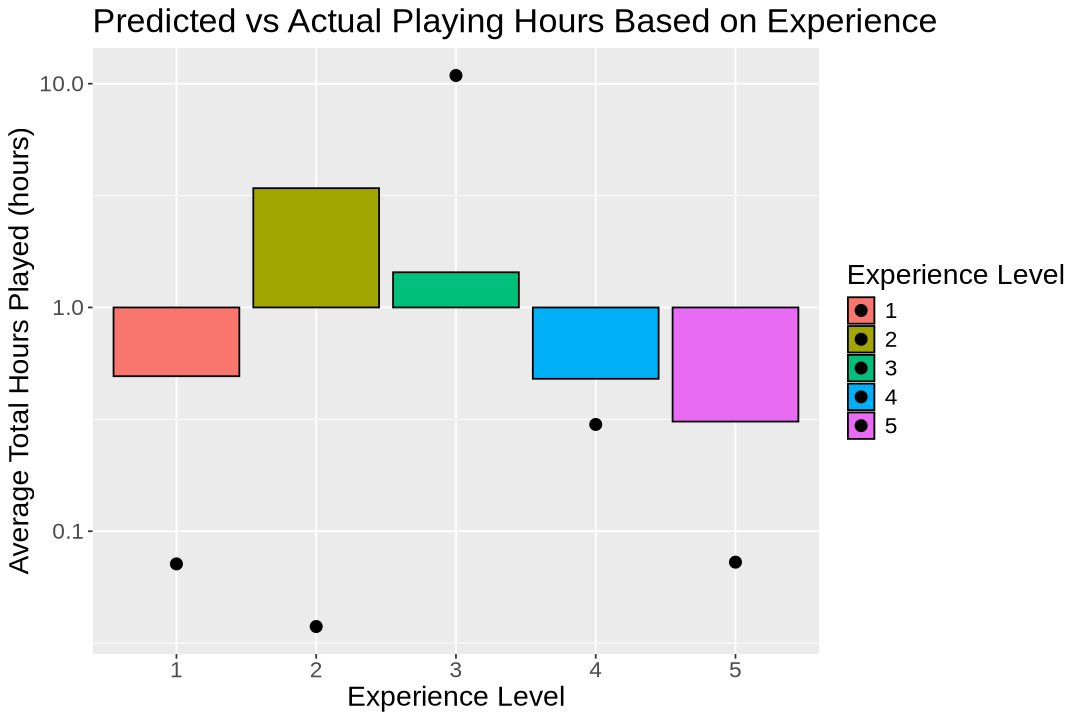

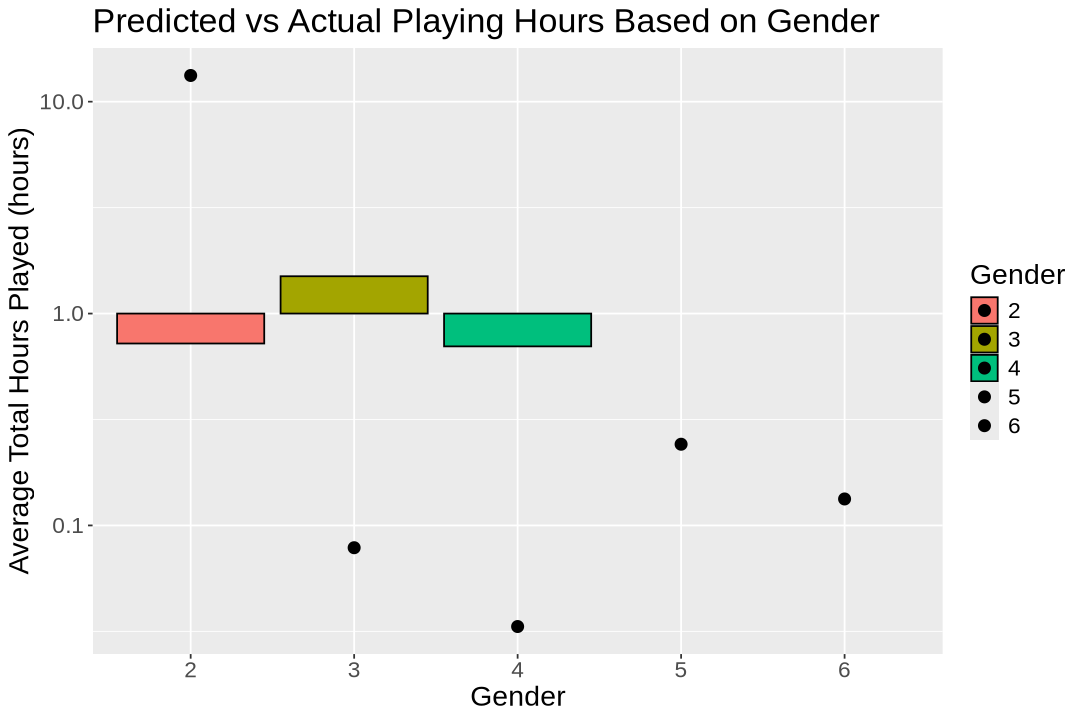

In [66]:
options(repr.plot.width = 9, repr.plot.height = 6)

players_experience_pred_plot <- ggplot(values_experience, aes(x = encoded_experience, y = mean_played_hours, fill = encoded_experience)) +
    geom_bar(stat = "summary", color = "black") +
    geom_point(aes(y = .pred), size = 3) +
    scale_y_log10() +
    labs(title = "Predicted vs Actual Playing Hours Based on Experience",
         x = "Experience Level", 
         y = "Average Total Hours Played (hours)",
         fill = 'Experience Level') + 
    theme(text = element_text(size = 17))
    
players_experience_pred_plot


players_gender_pred_plot <- ggplot(values_gender, aes(x = encoded_gender, y = mean_played_hours, fill = encoded_gender)) +
    geom_bar(stat = "summary", color = "black") +
    geom_point(aes(y = .pred), size = 3) +
    scale_y_log10() +
    labs(title = "Predicted vs Actual Playing Hours Based on Gender",
         x = "Gender", 
         y = "Average Total Hours Played (hours)",
         fill = 'Gender') + 
    theme(text = element_text(size = 17))
    
players_gender_pred_plot

## Discussion

**Results By Experience**:  
Players at Experience Level 2 (Beginner) spend the most time playing, averaging 3.41 hours. But the model greatly underestimates this, predicting only 0.04 hours. This shows that the model has trouble understanding the habits of beginner players. On the other hand, players at Experience Level 3 (Regular) actually play for 1.43 hours on average, but the model overestimates this to 10.88 hours. This shows a big overestimation for regular players.

For other levels, like Experience Levels 1 (Amateur), 4 (Pro), and 5 (Veteran), the actual playing time is lower, at 0.49, 0.48, and 0.31 hours respectively. The model does a bit better with these groups, predicting 0.07, 0.30, and 0.07 hours. But it still doesn't match the real data perfectly. This means the model is more accurate for less active players, but it still has trouble with the details.

**Results By Gender**:  
Gender 3 (Male) has the highest average actual playing hours, at 1.50, but the model greatly underestimates this group, predicting only 0.08 hours. This indicates that the model doesn't properly account for male players' behavior. Gender 2 (Female) has moderate actual playing hours at 0.72, but the model significantly overestimates their playing time at 13.29 hours, showing a strong bias in the predictions.

For Genders 4 (Non-binary), 5 (Prefer not to say), and 6 (Two-Spirited), the actual playing hours are either very low (0.7 for Non-binary) or zero (0.0 for Prefer not to say and Two-Spirited). The model's predictions for these groups (0.03, 0.24, and 0.13, respectively) are closer but still not accurate. This suggests that more data is needed to improve predictions for underrepresented groups.

**SUMMARY**:

This study on Minecraft players' playtime based on gender and experience showed significant differences between the actual hours played and the predicted hours. Beginners (Experience Level 2) played the most, with 3.41 hours, but their predicted playtime was much lower at 0.04 hours. Regular players (Experience Level 3) were predicted to play much more (10.88 hours) than they actually did (1.43 hours). For gender, males (Gender 3) had the highest average playtime (1.50 hours) but were predicted to play much less (0.08 hours). Females (Gender 2) played for a moderate amount of time (0.72 hours), but the prediction was much higher at 13.29 hours. Genders that are less common, like Non-binary (4) and Two-Spirited (6), had very low actual and predicted playtimes, showing some agreement but still not enough data.

The findings only partially aligned with expectations. It was anticipated that experienced players and more engaged demographics would exhibit higher playing hours. However, the significant underestimation of Beginners and certain gender groups, coupled with the overestimation of Regular players and others, was surprising. This indicates potential biases in the data or assumptions made by the model. Additionally, while predictions for underrepresented genders were relatively closer to actual hours, their low engagement suggests gaps in representation that require further exploration.

These results could change how Minecraft developers and researchers view player involvement. If they don't realize how much time new players spend, they might miss chances to keep these players interested. If they think regular players and women play more than they actually do, they might use resources in the wrong way for these groups.

**Future Questions**  
This study brings up several key questions:  


Data Collection: Are there biases in how data is gathered that affect results differently for men and women or for players with different levels of experience?  

Behavioral Patterns: Why do new players participate more than others, and how can this information help improve game design and keep players coming back?  

  Model Refinement: What other factors, like how people play, how long they play, or what they aim to achieve, could make predictions more accurate?  
  
  Inclusion: How can we gather more data from underrepresented groups to better understand how they interact with Minecraft?  
  
Cultural Influence: Do cultural aspects affect how much people play, and might these influences vary between men and women or between beginners and experienced players?  

